# Song Classifier System 

In [1]:
import pandas as pd
import numpy as np

## Spotify Streaming History 

In [2]:
streaming_history = pd.read_csv("Spotify_Streaming_History.csv", index_col=0)
streaming_history.head()

,endTime,artistName,trackName,msPlayed
0,2020-07-26 05:32,Fotty Seven,Chaud,192311
1,2020-07-27 07:34,DaBaby,ROCKSTAR (feat. Roddy Ricch),181733
2,2020-07-27 07:38,THE SCOTTS,THE SCOTTS,165977
3,2020-07-27 07:39,Logic,Perfect,100291
4,2020-07-27 07:43,Roddy Ricch,The Box,196652


In [3]:
streaming_history.shape

(10804, 4)

In [4]:
# Calculating the frequency of the different songs and getting a list of Unique songs 
unique_songs = streaming_history.groupby(['artistName', "trackName"]).size().to_frame('count').reset_index()
unique_songs.shape

(4233, 3)

In [5]:
unique_songs.sort_values(by = "count", ascending=False)

,artistName,trackName,count
548,Billie Eilish,bitches broken hearts,171
2104,Lauv,Love Somebody,161
3833,Troye Sivan,BITE,146
5,24kGoldn,Mood (feat. iann dior),145
1751,Jome,Cinnamon,136
...,...,...,...
1689,Jawsh 685,Savage Love (Laxed – Siren Beat) [BTS Remix],1
1691,Jay Wile,Numb,1
1695,Jaymes Young,Paradox,1
1696,Jaymes Young,Spaces,1


In order to classify a song as our favourite we decided to classify all songs that we have heard as our favourite. 

In [11]:
# Filtering out our favourite songs and creating a new dataframe for it
fav_songs = unique_songs[unique_songs["count"] > 0]
print(fav_songs.shape)
# fav_songs.sort_values(by="count", ascending=False)
fav_songs.head()

(4233, 3)


,artistName,trackName,count
0,1000 Beasts,It's Cool,1
1,2 Chainz,It's A Vibe,1
2,20TOKENS,ЩЕКАСТЫЕ,1
3,21 Savage,a lot,4
4,24kGoldn,"Mood (Remix) feat. Justin Bieber, J Balvin & i...",1


## Spotify Features

In [12]:
spotify_features = pd.read_csv("SpotifyFeatures.csv")
spotify_features.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [13]:
spotify_features.shape

(232725, 18)

In [14]:
spotify_features["track_id"].nunique()

176774

We had a lot of duplicates in the Spotify Features Dataset so using the track_id we filtered all of them

In [15]:
spotify_features["repeated"] = spotify_features["track_id"].duplicated()
spotify_features[spotify_features["repeated"] == True].shape

spotify_features = spotify_features[spotify_features["repeated"] != True]
spotify_features.drop("repeated", axis=1, inplace=True)

We match our favourite songs based on Artist Name and Track Name and we assign the value 1 if it is a favourite song, if not we assign 0  
- Favourite - 1   
- Not Favourite - 0   

In [16]:
spotify_features['similar_artists'] = spotify_features.artist_name.isin(fav_songs.artistName) 
spotify_features['similar_track'] = spotify_features.track_name.isin(fav_songs.trackName) 
spotify_features["favorite"] = np.where((spotify_features["similar_artists"] == True) & (spotify_features["similar_track"] == True),1,0)
spotify_features["favorite"].sum()

1869

Out of the 4233 favourite songs that we had, we have all the required data for 1869 of them. From this point, we will consider them to be our favourite songs and we will build our model using these 1869 songs. Since there is an obvious class imbalance problem, we will later use the SMOTE technique to tackle this. 

Note: Since this is just a prototype, we can proceed with the information for the 1869 songs to show that the idea works and can be implemented but for the actual project, we will be getting the data for all the favourite songs directly from Spotify solving the issue. 

In [17]:
# Unique genres in the spotify features dataset
spotify_features["genre"].unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Children’s Music', 'Rap', 'Indie',
       'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz', 'Rock', 'Ska',
       'Comedy', 'Soul', 'Soundtrack', 'World'], dtype=object)

In [18]:
spotify_features["genre"] = spotify_features["genre"].replace("Children's Music", 'Children’s Music')

In [19]:
# Unique genres to which our favourite songs belong to
spotify_features[spotify_features["favorite"] == 1]["genre"].unique()

array(['R&B', 'Alternative', 'Dance', 'Electronic', 'Folk', 'Blues',
       'Hip-Hop', 'Children’s Music', 'Rap', 'Indie', 'Classical', 'Pop',
       'Reggae', 'Reggaeton', 'Jazz', 'Rock', 'Soul', 'Soundtrack',
       'World', 'Country'], dtype=object)

We noticed that there is a genre called Comedy which we felt deserved a closer look

In [20]:
spotify_features[spotify_features["genre"] == "Comedy"].describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,favorite
count,9674.000000,9674.000000,9674.000000,9.674000e+03,9674.000000,9674.000000,9674.000000,9674.000000,9674.000000,9674.000000,9674.000000,9674.0
mean,21.320240,0.793449,0.559011,2.353424e+05,0.676169,0.000574,0.725113,-11.692845,0.854088,98.215501,0.412648,0.0
std,8.389576,0.129466,0.089591,2.503356e+05,0.211742,0.009991,0.223130,4.777678,0.204946,27.825530,0.207240,0.0
min,0.000000,0.000363,0.239000,3.004000e+04,0.001410,0.000000,0.025800,-31.047000,0.023000,32.451000,0.023700,0.0
25%,15.000000,0.753000,0.499000,1.218800e+05,0.522000,0.000000,0.662250,-14.652750,0.888000,79.705500,0.252000,0.0
50%,20.000000,0.819000,0.561000,1.891350e+05,0.704000,0.000000,0.767000,-11.210500,0.928000,90.111500,0.409500,0.0
75%,26.000000,0.872000,0.620000,2.813035e+05,0.859000,0.000000,0.898000,-8.092250,0.944000,115.109000,0.561000,0.0
max,56.000000,0.995000,0.898000,5.552917e+06,0.998000,0.352000,0.996000,-0.255000,0.967000,207.157000,0.980000,0.0


The Comedy genre had little to no values for instrumentalness and high values for duration_ms, liveness, and speechiness indicating that it could have been a podcast or part of a live show that was available on spotify. Since these aren't songs, we decided to remove them from the dataset. 

In [21]:
# Removing all genres that aren't there in our favourite songs
spotify_features = spotify_features[spotify_features["genre"].isin(spotify_features[spotify_features["favorite"] == 1]["genre"].unique())]
spotify_features.shape

(133947, 21)

In [22]:
spotify_features["genre"].unique()

array(['R&B', 'Alternative', 'Country', 'Dance', 'Electronic', 'Folk',
       'Blues', 'Hip-Hop', 'Children’s Music', 'Rap', 'Indie',
       'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz', 'Rock', 'Soul',
       'Soundtrack', 'World'], dtype=object)

## Data Preprocessing 

In [23]:
# The number of cases for each label 
spotify_features["favorite"].value_counts()

0    132078
1      1869
Name: favorite, dtype: int64

In [24]:
df = spotify_features.copy().reset_index()
df.head()

,index,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,similar_artists,similar_track,favorite
0,135,R&B,Mary J. Blige,Be Without You - Kendu Mix,2YegxR5As7BeQuVp2U6pek,65,0.0830,0.724,246333,0.689,...,0.3040,-5.922,Minor,0.1350,146.496,4/4,0.6930,False,False,0
1,136,R&B,Rihanna,Desperado,6KFaHC9G178beAp7P0Vi5S,63,0.3230,0.685,186467,0.610,...,0.1020,-5.221,Minor,0.0439,94.384,3/4,0.3230,True,False,0
2,137,R&B,Yung Bleu,Ice On My Baby (feat. Kevin Gates) - Remix,6muW8cSjJ3rusKJ0vH5olw,62,0.0675,0.762,199520,0.520,...,0.1140,-5.237,Minor,0.0959,75.047,4/4,0.0862,False,False,0
3,138,R&B,Surfaces,Heaven Falls / Fall on Me,7yHqOZfsXYlicyoMt62yC6,61,0.3600,0.563,240597,0.366,...,0.0955,-6.896,Minor,0.1210,85.352,4/4,0.7680,True,True,1
4,139,R&B,Olivia O'Brien,Love Myself,4XzgjxGKqULifVf7mnDIQK,68,0.5960,0.653,213947,0.621,...,0.0811,-5.721,Minor,0.0409,100.006,4/4,0.4660,True,False,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133947 entries, 0 to 133946
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             133947 non-null  int64  
 1   genre             133947 non-null  object 
 2   artist_name       133947 non-null  object 
 3   track_name        133947 non-null  object 
 4   track_id          133947 non-null  object 
 5   popularity        133947 non-null  int64  
 6   acousticness      133947 non-null  float64
 7   danceability      133947 non-null  float64
 8   duration_ms       133947 non-null  int64  
 9   energy            133947 non-null  float64
 10  instrumentalness  133947 non-null  float64
 11  key               133947 non-null  object 
 12  liveness          133947 non-null  float64
 13  loudness          133947 non-null  float64
 14  mode              133947 non-null  object 
 15  speechiness       133947 non-null  float64
 16  tempo             13

In [26]:
df.isna().sum()

index               0
genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
similar_artists     0
similar_track       0
favorite            0
dtype: int64

In [27]:
track_id = df["track_id"].tolist()
df.drop(["genre", "artist_name", "track_name", "track_id", "similar_track", "index", "time_signature"], axis=1, inplace=True)

In [28]:
df.columns.shape

(15,)

In [29]:
num_columns = [col for col in df.columns if df[col].dtype != 'O' and df[col].dtype != "bool"]
num_columns.remove("favorite")
cat_columns = [col for col in df.columns if df[col].dtype == 'O' or df[col].dtype == "bool"]
print(f'The Numerical columns are {num_columns}\n')
print(f'The categorical columns are {cat_columns}')

The Numerical columns are ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

The categorical columns are ['key', 'mode', 'similar_artists']


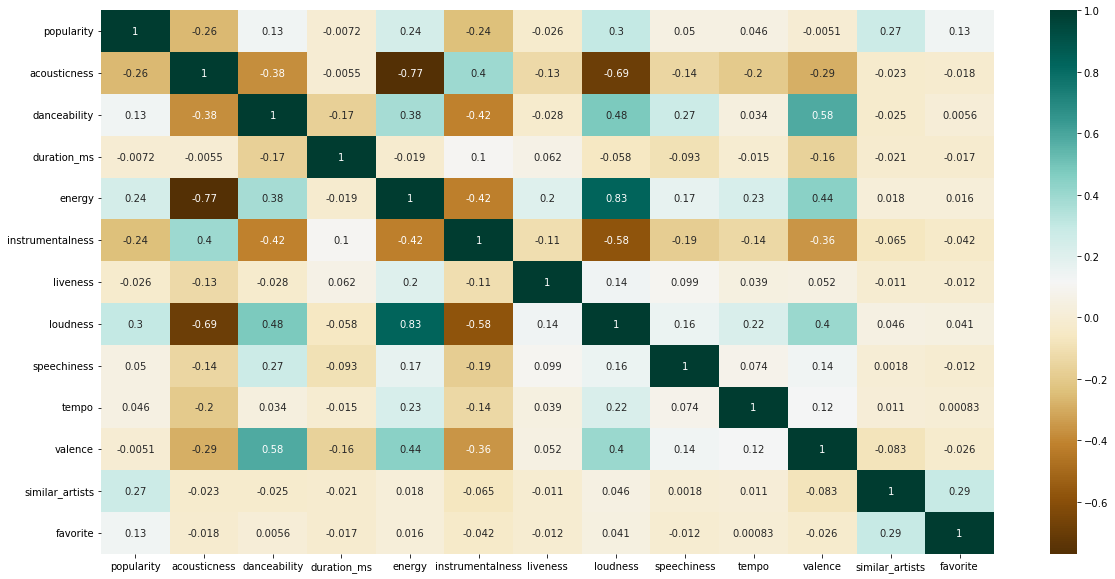

In [30]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), cmap = "BrBG", annot=True);

In [35]:
# Since we have a class imbalance problem, we are using SMOTE to tackle it
from imblearn.over_sampling import SMOTE
X = df[["popularity", "danceability", "instrumentalness", "loudness", "acousticness"]]
y = df["favorite"]
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(over_X, over_y, random_state=42, test_size=0.3)
X_train.shape, X_test.shape

((184909, 5), (79247, 5))

## Model Building

In [41]:

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def model_build(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=3)
    print(f'{type(model).__name__} has a {round(scores.mean(), 2)} accuracy with a standard deviation of {round(scores.std(),4)}')

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier


models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
for model in models:
    model_build(model, X_train, y_train)

LogisticRegression has a 0.75 accuracy with a standard deviation of 0.0023
DecisionTreeClassifier has a 0.91 accuracy with a standard deviation of 0.0013
RandomForestClassifier has a 0.94 accuracy with a standard deviation of 0.0014
GradientBoostingClassifier has a 0.8 accuracy with a standard deviation of 0.0036


In [44]:
model = CatBoostClassifier()
scores = cross_val_score(model, X_train, y_train, cv=3)
print(f'{type(model).__name__} has a {round(scores.mean(), 2)} accuracy with a standard deviation of {round(scores.std(),4)}')

Learning rate set to 0.080488
0:	learn: 0.6490806	total: 176ms	remaining: 2m 55s
1:	learn: 0.6146571	total: 189ms	remaining: 1m 34s
2:	learn: 0.5863758	total: 203ms	remaining: 1m 7s
3:	learn: 0.5644834	total: 216ms	remaining: 53.7s
4:	learn: 0.5457714	total: 229ms	remaining: 45.6s
5:	learn: 0.5310527	total: 241ms	remaining: 39.9s
6:	learn: 0.5185295	total: 251ms	remaining: 35.5s
7:	learn: 0.5074977	total: 261ms	remaining: 32.4s
8:	learn: 0.4984242	total: 272ms	remaining: 30s
9:	learn: 0.4910671	total: 283ms	remaining: 28.1s
10:	learn: 0.4833394	total: 294ms	remaining: 26.4s
11:	learn: 0.4779853	total: 306ms	remaining: 25.2s
12:	learn: 0.4731016	total: 317ms	remaining: 24.1s
13:	learn: 0.4673974	total: 327ms	remaining: 23.1s
14:	learn: 0.4634159	total: 339ms	remaining: 22.2s
15:	learn: 0.4596700	total: 350ms	remaining: 21.5s
16:	learn: 0.4564455	total: 361ms	remaining: 20.9s
17:	learn: 0.4535224	total: 373ms	remaining: 20.4s
18:	learn: 0.4509978	total: 386ms	remaining: 19.9s
19:	learn: 

165:	learn: 0.3725215	total: 2.12s	remaining: 10.7s
166:	learn: 0.3723098	total: 2.13s	remaining: 10.6s
167:	learn: 0.3721196	total: 2.14s	remaining: 10.6s
168:	learn: 0.3719004	total: 2.15s	remaining: 10.6s
169:	learn: 0.3716836	total: 2.17s	remaining: 10.6s
170:	learn: 0.3713418	total: 2.18s	remaining: 10.6s
171:	learn: 0.3710091	total: 2.19s	remaining: 10.5s
172:	learn: 0.3707164	total: 2.2s	remaining: 10.5s
173:	learn: 0.3704658	total: 2.21s	remaining: 10.5s
174:	learn: 0.3702515	total: 2.22s	remaining: 10.5s
175:	learn: 0.3699806	total: 2.23s	remaining: 10.5s
176:	learn: 0.3697743	total: 2.25s	remaining: 10.4s
177:	learn: 0.3694976	total: 2.26s	remaining: 10.4s
178:	learn: 0.3693128	total: 2.27s	remaining: 10.4s
179:	learn: 0.3689264	total: 2.28s	remaining: 10.4s
180:	learn: 0.3687444	total: 2.29s	remaining: 10.4s
181:	learn: 0.3685273	total: 2.3s	remaining: 10.4s
182:	learn: 0.3684009	total: 2.32s	remaining: 10.3s
183:	learn: 0.3681394	total: 2.33s	remaining: 10.3s
184:	learn: 0.

329:	learn: 0.3399216	total: 4.02s	remaining: 8.16s
330:	learn: 0.3398498	total: 4.03s	remaining: 8.15s
331:	learn: 0.3396423	total: 4.05s	remaining: 8.14s
332:	learn: 0.3393917	total: 4.06s	remaining: 8.13s
333:	learn: 0.3392605	total: 4.07s	remaining: 8.11s
334:	learn: 0.3391762	total: 4.08s	remaining: 8.1s
335:	learn: 0.3390485	total: 4.09s	remaining: 8.09s
336:	learn: 0.3388206	total: 4.1s	remaining: 8.07s
337:	learn: 0.3387268	total: 4.11s	remaining: 8.05s
338:	learn: 0.3386092	total: 4.12s	remaining: 8.04s
339:	learn: 0.3383651	total: 4.13s	remaining: 8.03s
340:	learn: 0.3381999	total: 4.15s	remaining: 8.01s
341:	learn: 0.3380554	total: 4.16s	remaining: 8s
342:	learn: 0.3378601	total: 4.17s	remaining: 7.98s
343:	learn: 0.3378091	total: 4.18s	remaining: 7.97s
344:	learn: 0.3376459	total: 4.19s	remaining: 7.96s
345:	learn: 0.3374925	total: 4.2s	remaining: 7.94s
346:	learn: 0.3373645	total: 4.21s	remaining: 7.93s
347:	learn: 0.3372317	total: 4.22s	remaining: 7.91s
348:	learn: 0.3371

498:	learn: 0.3189296	total: 5.98s	remaining: 6.01s
499:	learn: 0.3188618	total: 6s	remaining: 6s
500:	learn: 0.3187876	total: 6.01s	remaining: 5.98s
501:	learn: 0.3187431	total: 6.02s	remaining: 5.97s
502:	learn: 0.3186167	total: 6.03s	remaining: 5.96s
503:	learn: 0.3185268	total: 6.04s	remaining: 5.95s
504:	learn: 0.3184159	total: 6.05s	remaining: 5.93s
505:	learn: 0.3183721	total: 6.07s	remaining: 5.92s
506:	learn: 0.3183274	total: 6.08s	remaining: 5.91s
507:	learn: 0.3182521	total: 6.09s	remaining: 5.9s
508:	learn: 0.3182224	total: 6.1s	remaining: 5.88s
509:	learn: 0.3181515	total: 6.11s	remaining: 5.87s
510:	learn: 0.3180586	total: 6.12s	remaining: 5.86s
511:	learn: 0.3179058	total: 6.13s	remaining: 5.84s
512:	learn: 0.3178396	total: 6.14s	remaining: 5.83s
513:	learn: 0.3177405	total: 6.15s	remaining: 5.82s
514:	learn: 0.3175924	total: 6.17s	remaining: 5.81s
515:	learn: 0.3175207	total: 6.18s	remaining: 5.79s
516:	learn: 0.3173585	total: 6.19s	remaining: 5.78s
517:	learn: 0.317248

666:	learn: 0.3037324	total: 7.91s	remaining: 3.95s
667:	learn: 0.3036594	total: 7.92s	remaining: 3.94s
668:	learn: 0.3035801	total: 7.93s	remaining: 3.93s
669:	learn: 0.3035152	total: 7.95s	remaining: 3.91s
670:	learn: 0.3034583	total: 7.96s	remaining: 3.9s
671:	learn: 0.3033698	total: 7.97s	remaining: 3.89s
672:	learn: 0.3033261	total: 7.98s	remaining: 3.88s
673:	learn: 0.3032201	total: 7.99s	remaining: 3.87s
674:	learn: 0.3031290	total: 8s	remaining: 3.85s
675:	learn: 0.3030763	total: 8.02s	remaining: 3.84s
676:	learn: 0.3030105	total: 8.03s	remaining: 3.83s
677:	learn: 0.3029458	total: 8.04s	remaining: 3.82s
678:	learn: 0.3028314	total: 8.05s	remaining: 3.81s
679:	learn: 0.3027193	total: 8.06s	remaining: 3.79s
680:	learn: 0.3026639	total: 8.07s	remaining: 3.78s
681:	learn: 0.3026040	total: 8.09s	remaining: 3.77s
682:	learn: 0.3025469	total: 8.1s	remaining: 3.76s
683:	learn: 0.3024752	total: 8.11s	remaining: 3.75s
684:	learn: 0.3024202	total: 8.12s	remaining: 3.73s
685:	learn: 0.302

834:	learn: 0.2902465	total: 9.86s	remaining: 1.95s
835:	learn: 0.2901651	total: 9.87s	remaining: 1.94s
836:	learn: 0.2900839	total: 9.88s	remaining: 1.92s
837:	learn: 0.2900335	total: 9.89s	remaining: 1.91s
838:	learn: 0.2899854	total: 9.9s	remaining: 1.9s
839:	learn: 0.2898849	total: 9.91s	remaining: 1.89s
840:	learn: 0.2898156	total: 9.92s	remaining: 1.88s
841:	learn: 0.2897723	total: 9.94s	remaining: 1.86s
842:	learn: 0.2897352	total: 9.95s	remaining: 1.85s
843:	learn: 0.2896980	total: 9.96s	remaining: 1.84s
844:	learn: 0.2896023	total: 9.97s	remaining: 1.83s
845:	learn: 0.2895120	total: 9.98s	remaining: 1.82s
846:	learn: 0.2894263	total: 9.99s	remaining: 1.8s
847:	learn: 0.2893787	total: 10s	remaining: 1.79s
848:	learn: 0.2892575	total: 10s	remaining: 1.78s
849:	learn: 0.2892097	total: 10s	remaining: 1.77s
850:	learn: 0.2890650	total: 10s	remaining: 1.76s
851:	learn: 0.2889937	total: 10s	remaining: 1.75s
852:	learn: 0.2889214	total: 10.1s	remaining: 1.73s
853:	learn: 0.2888610	tot

997:	learn: 0.2782916	total: 11.8s	remaining: 23.7ms
998:	learn: 0.2782175	total: 11.9s	remaining: 11.9ms
999:	learn: 0.2781365	total: 11.9s	remaining: 0us
Learning rate set to 0.080489
0:	learn: 0.6485818	total: 15.3ms	remaining: 15.3s
1:	learn: 0.6144620	total: 28.4ms	remaining: 14.2s
2:	learn: 0.5857078	total: 40.4ms	remaining: 13.4s
3:	learn: 0.5648795	total: 53.2ms	remaining: 13.3s
4:	learn: 0.5469105	total: 65.9ms	remaining: 13.1s
5:	learn: 0.5320959	total: 77.3ms	remaining: 12.8s
6:	learn: 0.5186505	total: 87.3ms	remaining: 12.4s
7:	learn: 0.5079648	total: 99.1ms	remaining: 12.3s
8:	learn: 0.4961081	total: 111ms	remaining: 12.2s
9:	learn: 0.4881790	total: 123ms	remaining: 12.2s
10:	learn: 0.4816374	total: 138ms	remaining: 12.4s
11:	learn: 0.4763265	total: 152ms	remaining: 12.5s
12:	learn: 0.4711981	total: 164ms	remaining: 12.4s
13:	learn: 0.4662306	total: 175ms	remaining: 12.4s
14:	learn: 0.4622699	total: 188ms	remaining: 12.4s
15:	learn: 0.4570549	total: 202ms	remaining: 12.4s


169:	learn: 0.3716377	total: 2.2s	remaining: 10.7s
170:	learn: 0.3713346	total: 2.21s	remaining: 10.7s
171:	learn: 0.3710777	total: 2.22s	remaining: 10.7s
172:	learn: 0.3708427	total: 2.23s	remaining: 10.7s
173:	learn: 0.3706137	total: 2.24s	remaining: 10.7s
174:	learn: 0.3703682	total: 2.25s	remaining: 10.6s
175:	learn: 0.3702595	total: 2.27s	remaining: 10.6s
176:	learn: 0.3698491	total: 2.28s	remaining: 10.6s
177:	learn: 0.3696617	total: 2.29s	remaining: 10.6s
178:	learn: 0.3693087	total: 2.3s	remaining: 10.6s
179:	learn: 0.3691785	total: 2.31s	remaining: 10.5s
180:	learn: 0.3688001	total: 2.32s	remaining: 10.5s
181:	learn: 0.3685865	total: 2.33s	remaining: 10.5s
182:	learn: 0.3681435	total: 2.35s	remaining: 10.5s
183:	learn: 0.3679443	total: 2.36s	remaining: 10.5s
184:	learn: 0.3678009	total: 2.37s	remaining: 10.4s
185:	learn: 0.3675168	total: 2.38s	remaining: 10.4s
186:	learn: 0.3672336	total: 2.4s	remaining: 10.4s
187:	learn: 0.3669833	total: 2.41s	remaining: 10.4s
188:	learn: 0.3

332:	learn: 0.3406246	total: 4.15s	remaining: 8.32s
333:	learn: 0.3404291	total: 4.17s	remaining: 8.31s
334:	learn: 0.3402623	total: 4.18s	remaining: 8.3s
335:	learn: 0.3401732	total: 4.19s	remaining: 8.28s
336:	learn: 0.3398437	total: 4.2s	remaining: 8.27s
337:	learn: 0.3397213	total: 4.21s	remaining: 8.26s
338:	learn: 0.3396323	total: 4.22s	remaining: 8.24s
339:	learn: 0.3394609	total: 4.24s	remaining: 8.22s
340:	learn: 0.3393700	total: 4.25s	remaining: 8.21s
341:	learn: 0.3392104	total: 4.26s	remaining: 8.2s
342:	learn: 0.3391269	total: 4.27s	remaining: 8.18s
343:	learn: 0.3389063	total: 4.28s	remaining: 8.17s
344:	learn: 0.3387680	total: 4.29s	remaining: 8.15s
345:	learn: 0.3386334	total: 4.3s	remaining: 8.14s
346:	learn: 0.3384279	total: 4.32s	remaining: 8.12s
347:	learn: 0.3383212	total: 4.33s	remaining: 8.11s
348:	learn: 0.3381993	total: 4.34s	remaining: 8.1s
349:	learn: 0.3380544	total: 4.35s	remaining: 8.09s
350:	learn: 0.3379375	total: 4.37s	remaining: 8.07s
351:	learn: 0.337

499:	learn: 0.3198202	total: 6.13s	remaining: 6.13s
500:	learn: 0.3196749	total: 6.14s	remaining: 6.12s
501:	learn: 0.3195929	total: 6.15s	remaining: 6.11s
502:	learn: 0.3194810	total: 6.17s	remaining: 6.09s
503:	learn: 0.3193093	total: 6.18s	remaining: 6.08s
504:	learn: 0.3192080	total: 6.19s	remaining: 6.07s
505:	learn: 0.3191328	total: 6.2s	remaining: 6.05s
506:	learn: 0.3190436	total: 6.21s	remaining: 6.04s
507:	learn: 0.3189670	total: 6.22s	remaining: 6.03s
508:	learn: 0.3188846	total: 6.24s	remaining: 6.01s
509:	learn: 0.3187545	total: 6.25s	remaining: 6s
510:	learn: 0.3186893	total: 6.26s	remaining: 5.99s
511:	learn: 0.3186084	total: 6.27s	remaining: 5.98s
512:	learn: 0.3185353	total: 6.28s	remaining: 5.96s
513:	learn: 0.3185066	total: 6.29s	remaining: 5.95s
514:	learn: 0.3184341	total: 6.3s	remaining: 5.94s
515:	learn: 0.3183046	total: 6.32s	remaining: 5.92s
516:	learn: 0.3182104	total: 6.33s	remaining: 5.91s
517:	learn: 0.3180877	total: 6.34s	remaining: 5.9s
518:	learn: 0.3180

667:	learn: 0.3033433	total: 8.1s	remaining: 4.03s
668:	learn: 0.3032392	total: 8.11s	remaining: 4.01s
669:	learn: 0.3031836	total: 8.12s	remaining: 4s
670:	learn: 0.3031012	total: 8.13s	remaining: 3.99s
671:	learn: 0.3030296	total: 8.15s	remaining: 3.98s
672:	learn: 0.3029685	total: 8.16s	remaining: 3.96s
673:	learn: 0.3029085	total: 8.17s	remaining: 3.95s
674:	learn: 0.3028717	total: 8.18s	remaining: 3.94s
675:	learn: 0.3027846	total: 8.19s	remaining: 3.93s
676:	learn: 0.3027094	total: 8.21s	remaining: 3.91s
677:	learn: 0.3026256	total: 8.22s	remaining: 3.9s
678:	learn: 0.3025486	total: 8.23s	remaining: 3.89s
679:	learn: 0.3024392	total: 8.24s	remaining: 3.88s
680:	learn: 0.3023536	total: 8.29s	remaining: 3.88s
681:	learn: 0.3022721	total: 8.31s	remaining: 3.88s
682:	learn: 0.3022373	total: 8.32s	remaining: 3.86s
683:	learn: 0.3021677	total: 8.34s	remaining: 3.85s
684:	learn: 0.3021205	total: 8.35s	remaining: 3.84s
685:	learn: 0.3019928	total: 8.36s	remaining: 3.83s
686:	learn: 0.301

834:	learn: 0.2901734	total: 10.1s	remaining: 1.99s
835:	learn: 0.2900544	total: 10.1s	remaining: 1.98s
836:	learn: 0.2900127	total: 10.1s	remaining: 1.97s
837:	learn: 0.2899583	total: 10.1s	remaining: 1.96s
838:	learn: 0.2898549	total: 10.1s	remaining: 1.94s
839:	learn: 0.2897660	total: 10.1s	remaining: 1.93s
840:	learn: 0.2897149	total: 10.2s	remaining: 1.92s
841:	learn: 0.2896839	total: 10.2s	remaining: 1.91s
842:	learn: 0.2895892	total: 10.2s	remaining: 1.9s
843:	learn: 0.2895284	total: 10.2s	remaining: 1.88s
844:	learn: 0.2894060	total: 10.2s	remaining: 1.87s
845:	learn: 0.2893511	total: 10.2s	remaining: 1.86s
846:	learn: 0.2892614	total: 10.2s	remaining: 1.85s
847:	learn: 0.2891649	total: 10.2s	remaining: 1.83s
848:	learn: 0.2891186	total: 10.2s	remaining: 1.82s
849:	learn: 0.2890378	total: 10.3s	remaining: 1.81s
850:	learn: 0.2888876	total: 10.3s	remaining: 1.8s
851:	learn: 0.2888000	total: 10.3s	remaining: 1.79s
852:	learn: 0.2887275	total: 10.3s	remaining: 1.77s
853:	learn: 0.

Learning rate set to 0.080489
0:	learn: 0.6476485	total: 13.4ms	remaining: 13.4s
1:	learn: 0.6120248	total: 24.9ms	remaining: 12.4s
2:	learn: 0.5838872	total: 36.2ms	remaining: 12s
3:	learn: 0.5616531	total: 47.9ms	remaining: 11.9s
4:	learn: 0.5421777	total: 59.4ms	remaining: 11.8s
5:	learn: 0.5269363	total: 70.6ms	remaining: 11.7s
6:	learn: 0.5145511	total: 83ms	remaining: 11.8s
7:	learn: 0.5038566	total: 94.3ms	remaining: 11.7s
8:	learn: 0.4946246	total: 105ms	remaining: 11.6s
9:	learn: 0.4864974	total: 116ms	remaining: 11.4s
10:	learn: 0.4798093	total: 127ms	remaining: 11.4s
11:	learn: 0.4724066	total: 137ms	remaining: 11.3s
12:	learn: 0.4674423	total: 147ms	remaining: 11.2s
13:	learn: 0.4634056	total: 158ms	remaining: 11.1s
14:	learn: 0.4591608	total: 168ms	remaining: 11.1s
15:	learn: 0.4561743	total: 180ms	remaining: 11.1s
16:	learn: 0.4532031	total: 193ms	remaining: 11.1s
17:	learn: 0.4503370	total: 204ms	remaining: 11.1s
18:	learn: 0.4470858	total: 217ms	remaining: 11.2s
19:	lea

175:	learn: 0.3668343	total: 2.14s	remaining: 10s
176:	learn: 0.3667182	total: 2.16s	remaining: 10s
177:	learn: 0.3665038	total: 2.17s	remaining: 10s
178:	learn: 0.3663389	total: 2.18s	remaining: 10s
179:	learn: 0.3661119	total: 2.19s	remaining: 10s
180:	learn: 0.3660037	total: 2.21s	remaining: 9.98s
181:	learn: 0.3657539	total: 2.22s	remaining: 9.96s
182:	learn: 0.3655248	total: 2.23s	remaining: 9.95s
183:	learn: 0.3652970	total: 2.24s	remaining: 9.93s
184:	learn: 0.3650343	total: 2.25s	remaining: 9.92s
185:	learn: 0.3647683	total: 2.26s	remaining: 9.9s
186:	learn: 0.3645791	total: 2.27s	remaining: 9.89s
187:	learn: 0.3642810	total: 2.29s	remaining: 9.87s
188:	learn: 0.3639549	total: 2.3s	remaining: 9.86s
189:	learn: 0.3637279	total: 2.31s	remaining: 9.84s
190:	learn: 0.3634920	total: 2.32s	remaining: 9.83s
191:	learn: 0.3632086	total: 2.33s	remaining: 9.81s
192:	learn: 0.3628924	total: 2.34s	remaining: 9.8s
193:	learn: 0.3625816	total: 2.35s	remaining: 9.79s
194:	learn: 0.3623488	tot

341:	learn: 0.3365290	total: 4.1s	remaining: 7.88s
342:	learn: 0.3362978	total: 4.11s	remaining: 7.87s
343:	learn: 0.3362036	total: 4.12s	remaining: 7.86s
344:	learn: 0.3361187	total: 4.13s	remaining: 7.85s
345:	learn: 0.3360057	total: 4.15s	remaining: 7.84s
346:	learn: 0.3358682	total: 4.16s	remaining: 7.83s
347:	learn: 0.3357934	total: 4.17s	remaining: 7.82s
348:	learn: 0.3355891	total: 4.18s	remaining: 7.8s
349:	learn: 0.3355057	total: 4.2s	remaining: 7.79s
350:	learn: 0.3353893	total: 4.21s	remaining: 7.78s
351:	learn: 0.3352230	total: 4.22s	remaining: 7.77s
352:	learn: 0.3350630	total: 4.23s	remaining: 7.75s
353:	learn: 0.3349836	total: 4.24s	remaining: 7.74s
354:	learn: 0.3349041	total: 4.25s	remaining: 7.73s
355:	learn: 0.3346887	total: 4.26s	remaining: 7.72s
356:	learn: 0.3345857	total: 4.28s	remaining: 7.7s
357:	learn: 0.3344174	total: 4.29s	remaining: 7.7s
358:	learn: 0.3343354	total: 4.3s	remaining: 7.68s
359:	learn: 0.3342756	total: 4.31s	remaining: 7.67s
360:	learn: 0.3341

507:	learn: 0.3166919	total: 6.06s	remaining: 5.87s
508:	learn: 0.3165993	total: 6.07s	remaining: 5.86s
509:	learn: 0.3163758	total: 6.08s	remaining: 5.84s
510:	learn: 0.3162766	total: 6.09s	remaining: 5.83s
511:	learn: 0.3161342	total: 6.1s	remaining: 5.82s
512:	learn: 0.3159716	total: 6.12s	remaining: 5.81s
513:	learn: 0.3158582	total: 6.13s	remaining: 5.79s
514:	learn: 0.3157885	total: 6.14s	remaining: 5.78s
515:	learn: 0.3156649	total: 6.15s	remaining: 5.77s
516:	learn: 0.3156133	total: 6.17s	remaining: 5.76s
517:	learn: 0.3154388	total: 6.17s	remaining: 5.75s
518:	learn: 0.3153507	total: 6.21s	remaining: 5.76s
519:	learn: 0.3151989	total: 6.23s	remaining: 5.75s
520:	learn: 0.3151198	total: 6.24s	remaining: 5.74s
521:	learn: 0.3150224	total: 6.25s	remaining: 5.72s
522:	learn: 0.3148795	total: 6.26s	remaining: 5.71s
523:	learn: 0.3148350	total: 6.27s	remaining: 5.7s
524:	learn: 0.3147151	total: 6.28s	remaining: 5.68s
525:	learn: 0.3146720	total: 6.29s	remaining: 5.67s
526:	learn: 0.

674:	learn: 0.3003056	total: 8.25s	remaining: 3.97s
675:	learn: 0.3002705	total: 8.27s	remaining: 3.96s
676:	learn: 0.3001663	total: 8.28s	remaining: 3.95s
677:	learn: 0.3000916	total: 8.29s	remaining: 3.94s
678:	learn: 0.3000080	total: 8.31s	remaining: 3.93s
679:	learn: 0.2999304	total: 8.32s	remaining: 3.92s
680:	learn: 0.2998604	total: 8.33s	remaining: 3.9s
681:	learn: 0.2997205	total: 8.35s	remaining: 3.89s
682:	learn: 0.2995910	total: 8.36s	remaining: 3.88s
683:	learn: 0.2995358	total: 8.37s	remaining: 3.87s
684:	learn: 0.2994342	total: 8.38s	remaining: 3.85s
685:	learn: 0.2993772	total: 8.4s	remaining: 3.84s
686:	learn: 0.2993170	total: 8.41s	remaining: 3.83s
687:	learn: 0.2992404	total: 8.42s	remaining: 3.82s
688:	learn: 0.2991806	total: 8.44s	remaining: 3.81s
689:	learn: 0.2991014	total: 8.45s	remaining: 3.8s
690:	learn: 0.2990655	total: 8.46s	remaining: 3.79s
691:	learn: 0.2990271	total: 8.48s	remaining: 3.77s
692:	learn: 0.2989659	total: 8.49s	remaining: 3.76s
693:	learn: 0.2

836:	learn: 0.2878797	total: 10.4s	remaining: 2.04s
837:	learn: 0.2877655	total: 10.5s	remaining: 2.02s
838:	learn: 0.2877239	total: 10.5s	remaining: 2.01s
839:	learn: 0.2876187	total: 10.5s	remaining: 2s
840:	learn: 0.2875343	total: 10.5s	remaining: 1.99s
841:	learn: 0.2874692	total: 10.5s	remaining: 1.97s
842:	learn: 0.2874061	total: 10.5s	remaining: 1.96s
843:	learn: 0.2873270	total: 10.5s	remaining: 1.95s
844:	learn: 0.2872751	total: 10.6s	remaining: 1.94s
845:	learn: 0.2872050	total: 10.6s	remaining: 1.93s
846:	learn: 0.2871359	total: 10.6s	remaining: 1.91s
847:	learn: 0.2869838	total: 10.6s	remaining: 1.9s
848:	learn: 0.2869352	total: 10.6s	remaining: 1.89s
849:	learn: 0.2868088	total: 10.6s	remaining: 1.88s
850:	learn: 0.2867496	total: 10.7s	remaining: 1.87s
851:	learn: 0.2866892	total: 10.7s	remaining: 1.85s
852:	learn: 0.2866507	total: 10.7s	remaining: 1.84s
853:	learn: 0.2866125	total: 10.7s	remaining: 1.83s
854:	learn: 0.2865458	total: 10.7s	remaining: 1.82s
855:	learn: 0.28

997:	learn: 0.2775213	total: 12.8s	remaining: 25.6ms
998:	learn: 0.2774854	total: 12.8s	remaining: 12.8ms
999:	learn: 0.2773629	total: 12.8s	remaining: 0us
CatBoostClassifier has a 0.88 accuracy with a standard deviation of 0.0024


Based on the above accuracy scores, we decide to proceed with a Random Forest Model which has the maximum accuracy score of 0.94

In [49]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test) 
accuracy_score(preds, y_test)

0.9528057844460989

In [50]:
from sklearn.metrics import classification_report
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     37190
           1       0.98      0.93      0.95     42057

    accuracy                           0.95     79247
   macro avg       0.95      0.95      0.95     79247
weighted avg       0.95      0.95      0.95     79247



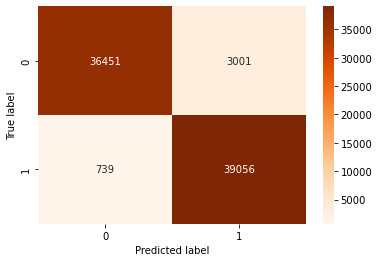

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)

columns = np.unique(y_test)

df_cm = pd.DataFrame(cm, index=columns, columns=columns)
ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(preds, y_test), recall_score(preds, y_test), f1_score(preds, y_test)

(0.9814298278678226, 0.9286444587107973, 0.9543077750085521)

In [58]:
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_leaf = [1, 2, 4]
param_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               #'max_depth': max_depth,
              #'min_samples_leaf': min_samples_leaf
             }
param_grid

{'n_estimators': [100, 200, 300, 400, 500]}

In [59]:
rf = RandomForestClassifier(random_state=42)
gcv = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, refit=True, scoring="accuracy", cv=3)
gcv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy')

In [60]:
gcv.best_score_

0.9434208137390337

In [62]:
from pycaret.classification import *

In [73]:
data = df[["popularity", "danceability", "instrumentalness", "loudness", "acousticness", "favorite"]]
over_X["favorite"] = over_y

In [77]:
exp_clf101 = setup(data = over_X, target = 'favorite', train_size = 0.7, fold_shuffle=True) 

,Description,Value
0,session_id,6463
1,Target,favorite
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(264156, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [78]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9567,0.9943,0.9841,0.9331,0.9579,0.9133,0.9147,3.1910
rf,Random Forest Classifier,0.9519,0.9914,0.9807,0.9274,0.9533,0.9037,0.9052,6.1550
dt,Decision Tree Classifier,0.9207,0.9207,0.9395,0.9058,0.9223,0.8414,0.8420,0.2440
knn,K Neighbors Classifier,0.9052,0.9563,0.9744,0.8562,0.9115,0.8103,0.8182,0.5340
catboost,CatBoost Classifier,0.8830,0.9472,0.9339,0.8479,0.8888,0.7659,0.7699,12.3250
xgboost,Extreme Gradient Boosting,0.8701,0.9418,0.9212,0.8362,0.8766,0.7401,0.7440,3.3860
lightgbm,Light Gradient Boosting Machine,0.8405,0.9183,0.8910,0.8098,0.8484,0.6809,0.6844,0.5310
gbc,Gradient Boosting Classifier,0.8034,0.8828,0.8556,0.7752,0.8135,0.6066,0.6100,4.7620
ada,Ada Boost Classifier,0.7864,0.8650,0.8346,0.7618,0.7966,0.5727,0.5753,1.2450
ridge,Ridge Classifier,0.7463,0.0000,0.7797,0.7316,0.7549,0.4925,0.4936,0.0750


In [79]:
rf = create_model('rf')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9505,0.9914,0.9805,0.9251,0.9520,0.9009,0.9025
1,0.9521,0.9917,0.9808,0.9277,0.9535,0.9042,0.9056
2,0.9528,0.9918,0.9796,0.9300,0.9542,0.9057,0.9070
3,0.9521,0.9915,0.9799,0.9284,0.9535,0.9042,0.9056
4,0.9494,0.9909,0.9807,0.9231,0.9510,0.8987,0.9005
5,0.9526,0.9917,0.9826,0.9272,0.9541,0.9052,0.9069
6,0.9525,0.9913,0.9808,0.9285,0.9539,0.9050,0.9065
7,0.9529,0.9914,0.9811,0.9289,0.9543,0.9058,0.9072
8,0.9523,0.9910,0.9796,0.9291,0.9537,0.9046,0.9059
9,0.9514,0.9918,0.9819,0.9256,0.9529,0.9027,0.9044


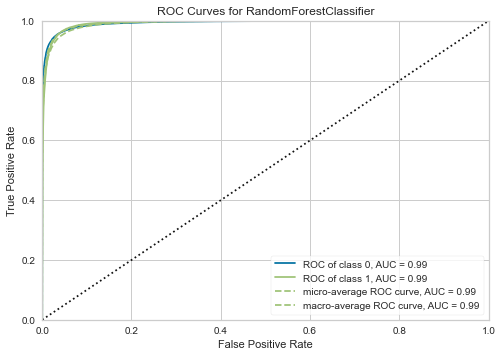

In [82]:
plot_model(rf, plot="auc")

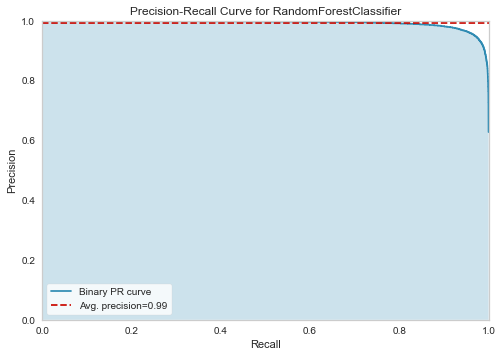

In [83]:
plot_model(rf, plot="pr")

In [91]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=6463, verbose=0, warm_start=False)

In [92]:
import pickle
pickle.dump(rf, open("Song_classifier_RF.pkl", "wb"))